<a href="https://colab.research.google.com/github/Sheepybloke2-0/CSE847-Project/blob/main/Model_Training/tinyml_seedling_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Check that imports for the rest of the file work.
import tensorflow as tf

!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q kaggle
! pip install -q tensorflow-model-optimization

!apt-get update && apt-get -qq install xxd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Allow matplotlib images to render immediately.
%matplotlib inline

import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
import tensorflow_model_optimization as tfmot
import tempfile

from IPython import display

     |████████████████████████████████| 1.0MB 18.7MB/s 
     |████████████████████████████████| 174kB 18.2MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [339 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:11 http://security.ubuntu.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
from google.colab import files
import pathlib
kaggleJson = pathlib.Path("/content/.kaggle/kaggle.json")
if not kaggleJson.is_file():
  # files.upload()
  !mkdir -p /content/.kaggle/
  %cd /content/gdrive/My\ Drive/
  !cp ./kaggle.json /content/.kaggle/
  !chmod 600 /content/.kaggle/kaggle.json
%env KAGGLE_CONFIG_DIR=/content/.kaggle
!echo $KAGGLE_CONFIG_DIR
!kaggle config view
!kaggle datasets list

/content/gdrive/My Drive
env: KAGGLE_CONFIG_DIR=/content/.kaggle
/content/.kaggle
Configuration values from /content/.kaggle
- username: drewhayward
- path: None
- proxy: None
- competition: None
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              216KB  2021-03-20 10:17:31            647  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            504  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            546  
imsparsh/musicnet-dataset         

In [6]:
# NOTE: Remove the zip file and redownload if the unzip isn't working properly
imageZip = pathlib.Path('/content/gdrive/My Drive/v2-plant-seedlings-dataset.zip')
if not imageZip.is_file():
  !kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset
  !ls
else:
  %cd /content/gdrive/My\ Drive/
!unzip v2-plant-seedlings-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/nonsegmentedv2/Charlock/308.png  
  inflating: /content/nonsegmentedv2/Charlock/309.png  
  inflating: /content/nonsegmentedv2/Charlock/31.png  
  inflating: /content/nonsegmentedv2/Charlock/310.png  
  inflating: /content/nonsegmentedv2/Charlock/311.png  
  inflating: /content/nonsegmentedv2/Charlock/312.png  
  inflating: /content/nonsegmentedv2/Charlock/313.png  
  inflating: /content/nonsegmentedv2/Charlock/314.png  
  inflating: /content/nonsegmentedv2/Charlock/315.png  
  inflating: /content/nonsegmentedv2/Charlock/316.png  
  inflating: /content/nonsegmentedv2/Charlock/317.png  
  inflating: /content/nonsegmentedv2/Charlock/318.png  
  inflating: /content/nonsegmentedv2/Charlock/319.png  
  inflating: /content/nonsegmentedv2/Charlock/32.png  
  inflating: /content/nonsegmentedv2/Charlock/320.png  
  inflating: /content/nonsegmentedv2/Charlock/321.png  
  inflating: /content/nonsegmentedv2/Charlock/322.png  

In [7]:
rootDir = pathlib.Path('/content/')
%cd /content/
!rm -r sample_data

imageCount = len(list(rootDir.glob('nonsegmentedv2/*/*.png')))
print(imageCount)

/content
5539


In [8]:
# CONSTANTS GO HERE
BUFFER_SIZE = imageCount
BATCH_SIZE = 256
IM_SIZE = (128, 128)
IM_DIMS = (128, 128,3)
EPOCHS = 100
FULL_MODEL = '/content/gdrive/My Drive/full_model'
LITE_MODEL = '/content/gdrive/My Drive/lite_model.tflite'
LITE_MODEL_ESC = '/content/gdrive/My\ Drive/lite_model.tflite'
QUANT_MODEL = '/content/gdrive/My Drive/quant_model.tflite'
QUANT_MODEL_ESC = '/content/gdrive/My\ Drive/quant_model.tflite'
MICRO_MODEL = '/content/gdrive/My Drive/micro_model.cc'
MICRO_MODEL_ESC = '/content/gdrive/My\ Drive/micro_model.cc'

In [9]:
trainPath = os.path.join(rootDir, 'nonsegmentedv2')

trainDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    trainPath,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IM_SIZE,
    batch_size=BATCH_SIZE
)

testDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    trainPath,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IM_SIZE,
    batch_size=BATCH_SIZE
)
classNames = trainDataSet.class_names
print(classNames)

Found 5539 files belonging to 12 classes.
Using 4432 files for training.
Found 5539 files belonging to 12 classes.
Using 1107 files for validation.
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdтАЩs Purse', 'Small-flowered Cranesbill', 'Sugar beet']


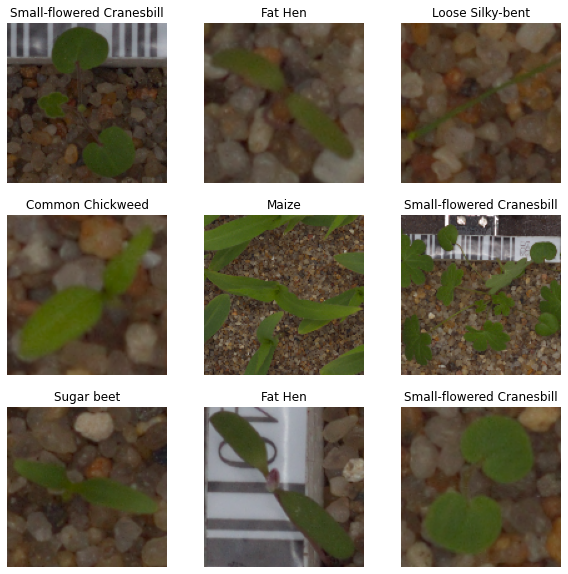

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in trainDataSet.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])
    plt.axis("off")

In [10]:
def classificationModel(trainImgs, testImgs):
  L2_lambda = 0.01
  data_augmentation = tf.keras.Sequential(
  [ layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=IM_DIMS),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),])

  model = tf.keras.Sequential()
  model.add(data_augmentation)
  model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=IM_DIMS))
  model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=IM_DIMS, kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2,2)))

  model.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2,2)))

  model.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.BatchNormalization())

  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))
  model.add(layers.Dense(len(trainImgs.class_names), kernel_regularizer=tf.keras.regularizers.l2(L2_lambda)))

  model.summary()
  schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, 100000, 0.98)
  opt = tf.keras.optimizers.Adam(learning_rate=schedule)
  model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  return model.fit(trainImgs, validation_data=testImgs, epochs=EPOCHS)

In [ ]:
history = classificationModel(trainDataSet, testDataSet)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 32)       

In [14]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(history.model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /tmp/tmps09scz8n.h5


In [ ]:
pruning_lm = tfmot.sparsity.keras.prune_low_magnitude

iters = 2

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=(np.ceil(4432/BATCH_SIZE)*iters))
}

model_for_pruning = pruning_lm(history.model, **pruning_params)
model_for_pruning.summary()



ValueError: ignored

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/full_model/assets


Text(0.5, 1.0, 'Training/Test Loss')

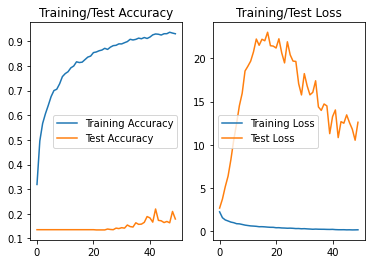

In [15]:
history.model.save(FULL_MODEL)

acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

loss = history.history['loss']
test_loss = history.history['val_loss']

epochs_rng = range(EPOCHS)

plt.subplot(1,2, 1)
plt.plot(epochs_rng, acc, label='Training Accuracy')
plt.plot(epochs_rng, test_acc, label='Test Accuracy')
plt.legend()
plt.title('Training/Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_rng, loss, label='Training Loss')
plt.plot(epochs_rng, test_loss, label='Test Loss')
plt.legend()
plt.title('Training/Test Loss')

In [ ]:
# TODO: Add data augementation to increase the number of training samples?
# https://www.tensorflow.org/tutorials/images/classification

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(FULL_MODEL)
model_no_quant_tflite = converter.convert()

# Now test with quantazation for int8: 
# https://stackoverflow.com/questions/65902185/tfliteconverter-representative-dataset-from-keras-preprocessing-image-dataset-fr
def representative_dataset():
  for images, labels in testDataSet.batch(1).take(100):
    yield [images]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
model_quant_tflite = converter.convert()

# Save the model to disk
open(LITE_MODEL, "wb").write(model_no_quant_tflite)
open(QUANT_MODEL, "wb").write(model_quant_tflite)

RuntimeError: ignored

In [ ]:
# TODO: Add some testing to compare the models

In [ ]:
# Check the size of the model
# Calculate size
size_tf = os.path.getsize(FULL_MODEL)
size_tflite = os.path.getsize(LITE_MODEL)
size_quant = os.path.getsize(QUANT_MODEL)

pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_tflite} bytes ", f"(reduced by {size_tf - size_tflite} bytes)"]],
     ["TensorFlow Quant Lite", f"{size_quant} bytes ", f"(reduced by {size_tflite - size_quant} bytes)"]],
     columns=["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,44705680 bytes,(reduced by -44701584 bytes)


In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {LITE_MODEL_ESC} > {MICRO_MODEL_ESC}
# Update variable names
REPLACE_TEXT = LITE_MODEL.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MICRO_MODEL}

sed: -e expression #1, char 20: unterminated `s' command


In [ ]:
# TODO: Write and deploy the model